# **Логистическая регрессия. Практика**

Для практики будем решать задачу оттока клиентов из банка. [**ДАТАСЕТ**](https://lms.skillfactory.ru/assets/courseware/v1/c903ecd0b0c995c44213d620ab6ae94d/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/churn.zip)

Вы уже знакомились с этой задачей в модуле по визуализации и провели небольшое исследование данных. В этом модуле мы построим классификатор, который позволит своевременно определять уходящих клиентов банка.

Для начала импортируем библиотеки, которые нам понадобятся:

In [2]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #разделение выборки
from sklearn import preprocessing #предобработка
%matplotlib inline
plt.style.use('seaborn')

In [3]:
# прочитаем нашу таблицу:
churn_data = pd.read_csv('data/churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Напомним значения столбцов:

* **RowNumber** — номер строки таблицы;
* **CustomerId** — идентификатор клиента;
* **Surname** — фамилия клиента;
* **CreditScore** — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);
* **Geography** — страна проживания клиента (банк межнациональный);
* **Gender** — пол клиента;
* **Age** — возраст клиента;
* **Tenure** — сколько лет клиент пользуется банком;
* **Balance** — сколько у клиента денег на счетах в банке;
* **NumOfProduct** — число услуг банка, которые приобрёл клиент;
* **HasCrCard** — есть ли у клиента кредитная карта (1 — да, 0 — нет);
* **IsActiveMember** — есть ли у клиента статус активного участника банка (1 — да, 0 — нет);
* **EstimatedSalary** — предполагаемая заработная плата клиента;
* **Exited** — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент).

В модуле по визуализации мы выяснили, что отток клиентов в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [4]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

In [5]:
# Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


In [6]:
# Проверим, что в наших данных нет пропусков:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Давайте расширим наш датасет с помощью методов Feature Engineering. Создадим следующие признаки:

* **BalanceSalaryRatio** — отношение баланса на счетах к заработной плате клиента;
* **TenureByAge** — отношение времени пользования банком к возрасту клиента;
* **CreditScoreGivenAge** — отношение кредитного рейтинга к возрасту клиента.

In [7]:
churn_data['BalanceSalaryRatio'] = churn_data['Balance']/churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure']/(churn_data['Age'])
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore']/(churn_data['Age'])

In [8]:
# Также перекодируем единственный текстовый категориальный признак
# Gender в бинарный столбец (1 — 'Male', 0 — 'Female'):
churn_data['Gender'] = churn_data['Gender'].apply(lambda x: 1 if x=='Male' else 0)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,0,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,1,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,1,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,1,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,0,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


Разделим набор данных на матрицу наблюдений X и столбец ответов y:

In [9]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

# И, наконец, заранее позаботимся о масштабах признаков.
# Проведём нормализацию матрицы наблюдений X:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, посмотрим на сбалансированность данных. Для этого воспользуемся методом **value_counts()** и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [10]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что наши классы не сбалансированы. Ушедших пользователей — 32 %, в то время как лояльных — 68 %. 

В чём может быть проблема? 

*При разделении нашего набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет оставлять желать лучшего.*

*Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать прекрасное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.*

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборках было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется стратифицированным. 

Как хорошо, что функция **train_test_split()** из библиотеки sklearn умеет производить такое разбиение! Для этого в функции предусмотрен параметр **stratify**, который нужно выставить в значение признака. Признак должен иметь одинаковые соотношения в тренировочной и тестовой выборках. У нас этим признаком является целевой признак ***y***.

In [11]:
# Выполним разбиение, установив значением параметра random_state число 0:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=0)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))
print('\n')

# Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:
print('TRAIN :', y_train.value_counts(normalize=True))
print('\n')
print('TEST :', y_test.value_counts(normalize=True))

Train shape: (1881, 12)
Test shape: (628, 12)


TRAIN : 0    0.675704
1    0.324296
Name: Exited, dtype: float64


TEST : 0    0.675159
1    0.324841
Name: Exited, dtype: float64


Соотношения одинаковы. А значит, мы можем приступить к заданиям.

## **ЗАДАЧИ**

Обучите модель логистической регрессии на тренировочных данных. Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. В качестве значения параметра random_state возьмите 42 для воспроизводимости результатов. Остальные параметры оставьте по умолчанию.

Предскажите метки классов для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на тренировочной и тестовой выборках? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [12]:
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(solver = 'sag', random_state=42)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)

#Делаем предсказание и смотрим метрику для тренировочной выборки
y_pred = log_reg.predict(X_train)
print('F1 Train: {:.2f}'.format(metrics.f1_score(y_train, y_pred)))

#Делаем предсказание и смотрим метрику для тестовой выборки
y_pred = log_reg.predict(X_test)
print('F1 Test: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

F1 Train: 0.49
F1 Test: 0.47


Сгенерируйте полиномиальные признаки степени 3 для тренировочной и тестовой выборок. Используйте класс **PolynomialFeatures** из библиотеки sklearn. Параметр **include_bias** выставите в значение False.

Чему равно количество признаков в тренировочной выборке?

In [13]:
# Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(1881, 454)
(628, 454)


Обучите модель логистической регрессии на полиномиальных признаках.

Используйте в качестве алгоритма минимизации функции потерь (параметр solver) стохастический градиентный спуск. Параметру random_state выставите значение 42 для воспроизводимости результатов. Увеличьте максимальное количество итераций, выделяемых на сходимость (параметр max_iter), до 1000.

Остальные параметры оставьте по умолчанию.

Предскажите метки классов для тренировочной и тестовой выборок.

Чему равно значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [14]:
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(solver = 'sag', random_state=42, max_iter=1000)
#Обучаем модель на полиномиальных признаках
log_reg.fit(X_train_poly, y_train)

#Делаем предсказание и смотрим метрику для тренировочной выборки
y_pred = log_reg.predict(X_train_poly)
print('F1 Train: {:.2f}'.format(metrics.f1_score(y_train, y_pred)))

#Делаем предсказание и смотрим метрику для тестовой выборки
y_pred = log_reg.predict(X_test_poly)
print('F1 Test: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

F1 Train: 0.66
F1 Test: 0.64


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. Используйте логистическую регрессию, обученную на полиномиальных признаках из предыдущего задания.

В качестве порога вероятности используйте значения из следующего диапазона:

                                            thresholds = np.arange(0.1, 1, 0.05)

Напомним алгоритм, как определить оптимальный порог вероятности:

1. Предсказать вероятности оттока для каждого клиента из тестовой выборки.
2. В цикле перебирать значения порогов вероятности threshold: сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0. Далее рассчитать метрику и занести её в заранее созданный список.
3. Постройте график зависимости целевой метрики от порога вероятности.

Какому порогу вероятности соответствует наибольшее значение целевой метрики? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [23]:
#Считаем вероятности наличия диабета для каждого из пациентов
#Нас интересует только вероятность класса (второй столбец)
y_proba_pred = log_reg.predict_proba(X_test_poly)[:, 1]
#Для удобства завернём numpy-массив в Pandas Series
y_proba_pred = pd.Series(y_proba_pred)

#Создадим списки, в которых будем хранить значения метрик 
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    y_pred = y_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    f1_scores.append(metrics.f1_score(y_test, y_pred))

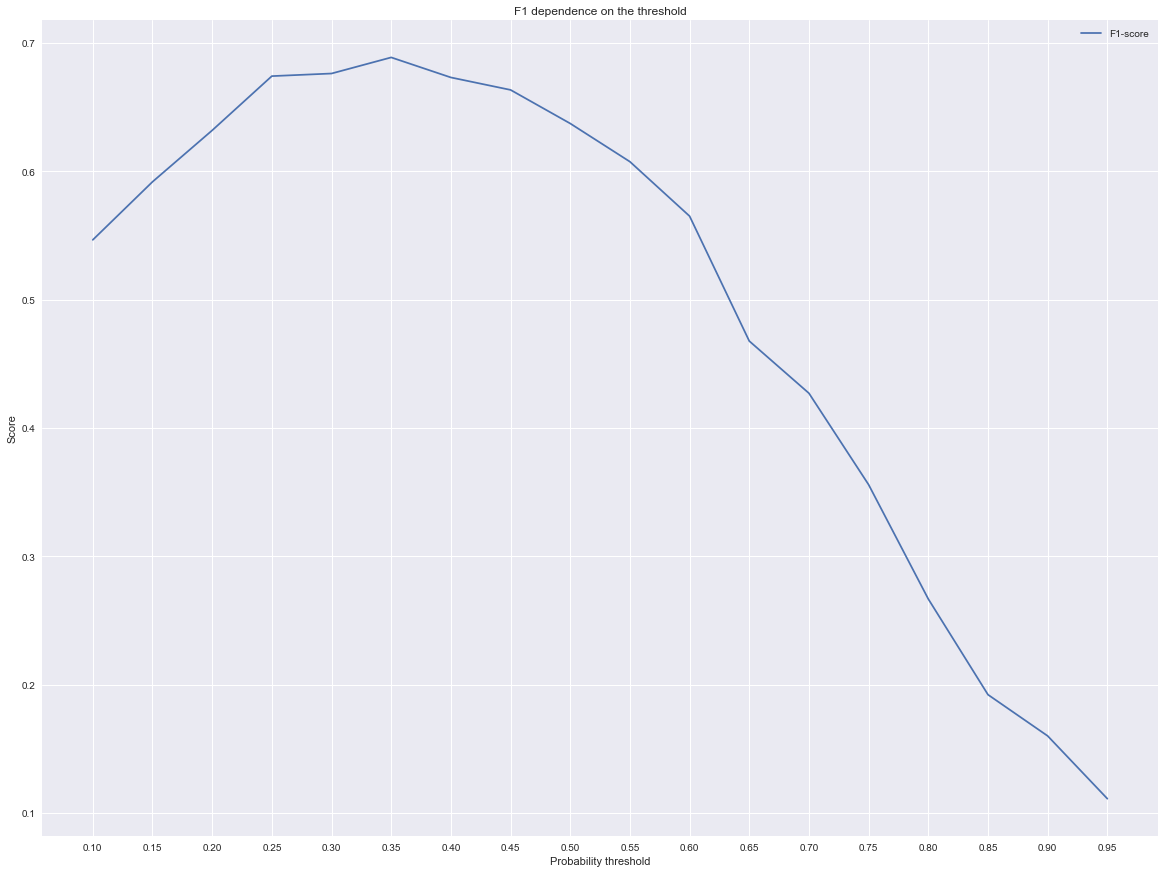

In [24]:
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(20, 15)) #фигура + координатная плоскость
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
 
#Даём графику название и подписываем оси
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
#Отображаем легенду
ax.legend();

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Чему равно значение целевой метрики на тестовой выборке? Ответ приведите с точностью до двух знаков после точки-разделителя.

In [27]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.35
y_pred_opt = y_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.f1_score(y_test, y_pred_opt).round(2))

0.69
